<a href="https://colab.research.google.com/github/ranjanguddu/Machine-Learning/blob/master/EVA4/Session-15/Assignment_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Mon May 25 05:01:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings("ignore")
#import zipfile
import time
from torchsummary import summary
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
#from PIL import Image
#from torchvision.transforms import transforms
import matplotlib.pyplot as plt
#import torchvision
import torch
#from torch import nn
#from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR

import os
import pandas as pd

from util import *
#from Losses import *

In [0]:
root = Path('/content/')

In [6]:
loc = "/content/drive/My Drive/Depth_Mask_Project.zip"
extract_RAW_DATA(loc)


100%|██████████| 154/154 [02:41<00:00,  1.05s/it]


In [7]:
dir_list = ['DEPTH_IMAGES','FG_BG_IMAGES', 'FG_BG_MASK']
bg_tracker = ['Tracker_file.txt.zip', 'street_bg.zip']
extract_data(dir_list, bg_tracker)
    

/content/Depth_Mask_Project/DEPTH_IMAGES/


100%|██████████| 80003/80003 [00:10<00:00, 7870.28it/s]


/content/Depth_Mask_Project/FG_BG_IMAGES/


100%|██████████| 40001/40001 [00:06<00:00, 6212.77it/s]


/content/Depth_Mask_Project/FG_BG_MASK/


100%|██████████| 105/105 [00:00<00:00, 446.59it/s]


In [0]:
! ls -l '/content/Unzipped_DATA/depth_image_batch1' | wc -l

In [0]:
bg_mean = [0.4066298566301917, 0.4002413496649073, 0.39249680184578123]
bg_std = [0.2516888771733121, 0.25270893840650427, 0.2627707634116584]

img_mean = [0.406589950038055, 0.3974733626335778, 0.3922238309037007]
img_std = [0.2537575580108365, 0.2544099256403426, 0.26358312983854404]

In [0]:
from DataGenerator import DepthMaskDataset
root_dir=root/'Unzipped_DATA'

dataset = DepthMaskDataset(root = root_dir, image_size=128, num_data=400000)  # transform=transforms.ToTensor()
train_set, test_set = torch.utils.data.random_split(dataset, [280000,120000])

In [11]:
train_loader = DataLoader(dataset=train_set, batch_size = 128, shuffle=True)
t1 = time.time()
dataiter = iter(train_loader)
data = dataiter.next()
t2 =time.time()
print(f'Time taken to create data loader of batch size {data[0].shape} is {t2-t1:.2f} seconds')

Time taken to create data loader of batch size torch.Size([128, 3, 224, 224]) is 1.42 seconds


In [59]:
for i in range(4):
    print(data[i].shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
torch.Size([16, 1, 224, 224])


In [20]:
from Model_UNET import UNET_Model
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = UNET_Model(n_class=1).to(device)
#summary(model, input_size=torch.cat((data[0][0], data[1][0]), dim=0).shape)
model.load_state_dict(torch.load('/content/drive/My Drive/saved_weight/Weight_after_Epoch_4_1.9278807030786993e-06.pth'))

cuda


<All keys matched successfully>

In [0]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum= 0.9, weight_decay = 1e-4)


In [0]:

result = Path(root/'saved_models/')
result.mkdir(exist_ok=True)
Path(root/"plots").mkdir(exist_ok=True)

save(data[2],f"/content/plots/Label_mask.jpg", 4 )
save(data[3],f"/content/plots/Label_depth.jpg", 4 )

In [0]:
from train_model import train_model

device = torch.device('cuda')
torch.cuda.current_device()
torch.cuda.get_device_name(0)
print(device)
best_loss=4
lr_scheduler = StepLR(optimizer, step_size=2, gamma = 0.1)
EPOCH=20
for epoch in range(EPOCH):
  
  print('Epoch {}/{}'.format(epoch+1, EPOCH))
  print('-' * 10)
  t0 = time.time()
  model, epoch_loss = train_model(model, criterion, device,train_loader,optimizer,epoch)
  
  if epoch_loss < best_loss:
      print("saving best model")
      best_loss = epoch_loss
      
      torch.save(model.state_dict(), f'/content/drive/My Drive/saved_weight/Weight_after_Epoch_{epoch+1}_{best_loss}.pth')

  time_elapsed = time.time() - t0
  print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  lr_scheduler.step()
  
torch.save(model.state_dict(), f'/content/drive/My Drive/saved_weight/FINALLY_Weight_after_Epoch_{epoch+1}_{best_loss.item()}.pth')
    

  0%|          | 0/17500 [00:00<?, ?it/s]

cuda
Epoch 1/20
----------


mask_loss:0.0257 depth_loss=0.5125 Loss = 0.5639 epoch_loss=2.0139036678301636e-06 : 100%|██████████| 17500/17500 [55:48<00:00,  5.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving best model


mask_loss:0.0270 depth_loss=0.5516 Loss = 0.6056 epoch_loss=0.037847455590963364 :   0%|          | 1/17500 [00:00<51:50,  5.63it/s]

55m 49s
Epoch 2/20
----------


mask_loss:0.0220 depth_loss=0.5698 Loss = 0.6137 epoch_loss=2.191847215726739e-06 : 100%|██████████| 17500/17500 [51:21<00:00,  5.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
mask_loss:0.0223 depth_loss=0.5318 Loss = 0.5765 epoch_loss=0.03603091463446617 :   0%|          | 0/17500 [00:00<?, ?it/s]

51m 22s
Epoch 3/20
----------


mask_loss:0.0222 depth_loss=0.5529 Loss = 0.5972 epoch_loss=2.1329199171304936e-06 : 100%|██████████| 17500/17500 [49:14<00:00,  5.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
mask_loss:0.0219 depth_loss=0.5220 Loss = 0.5657 epoch_loss=0.035356324166059494 :   0%|          | 1/17500 [00:00<48:44,  5.98it/s]

49m 15s
Epoch 4/20
----------


mask_loss:0.0240 depth_loss=0.4918 Loss = 0.5398 epoch_loss=1.9278807030786993e-06 : 100%|██████████| 17500/17500 [48:36<00:00,  6.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving best model


mask_loss:0.0224 depth_loss=0.4908 Loss = 0.5355 epoch_loss=0.03346981853246689 :   0%|          | 1/17500 [00:00<52:07,  5.59it/s]

48m 37s
Epoch 5/20
----------


mask_loss:0.0231 depth_loss=0.5133 Loss = 0.5596 epoch_loss=1.9987066934845643e-06 : 100%|██████████| 17500/17500 [46:46<00:00,  6.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
mask_loss:0.0227 depth_loss=0.5218 Loss = 0.5671 epoch_loss=0.03544415533542633 :   0%|          | 1/17500 [00:00<50:18,  5.80it/s]

46m 47s
Epoch 6/20
----------


mask_loss:0.0218 depth_loss=0.5209 Loss = 0.5645 epoch_loss=2.016029156948207e-06 : 100%|██████████| 17500/17500 [45:38<00:00,  6.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
mask_loss:0.0234 depth_loss=0.5155 Loss = 0.5622 epoch_loss=0.035140570253133774 :   0%|          | 1/17500 [00:00<47:23,  6.15it/s]

45m 39s
Epoch 7/20
----------


mask_loss:0.0226 depth_loss=0.5280 Loss = 0.5731 epoch_loss=2.0468585262278793e-06 : 100%|██████████| 17500/17500 [45:18<00:00,  6.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
mask_loss:0.0245 depth_loss=0.5363 Loss = 0.5853 epoch_loss=0.03657829761505127 :   0%|          | 1/17500 [00:00<48:34,  6.00it/s]

45m 19s
Epoch 8/20
----------


mask_loss:0.0216 depth_loss=0.5083 Loss = 0.5515 epoch_loss=1.9698054529726505e-06 : 100%|██████████| 17500/17500 [45:20<00:00,  6.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
mask_loss:0.0216 depth_loss=0.5181 Loss = 0.5613 epoch_loss=0.035080328583717346 :   0%|          | 1/17500 [00:00<52:23,  5.57it/s]

45m 21s
Epoch 9/20
----------


mask_loss:0.0222 depth_loss=0.5221 Loss = 0.5665 epoch_loss=5.0704588829830755e-06 :  40%|███▉      | 6983/17500 [17:04<26:43,  6.56it/s]

<All keys matched successfully>

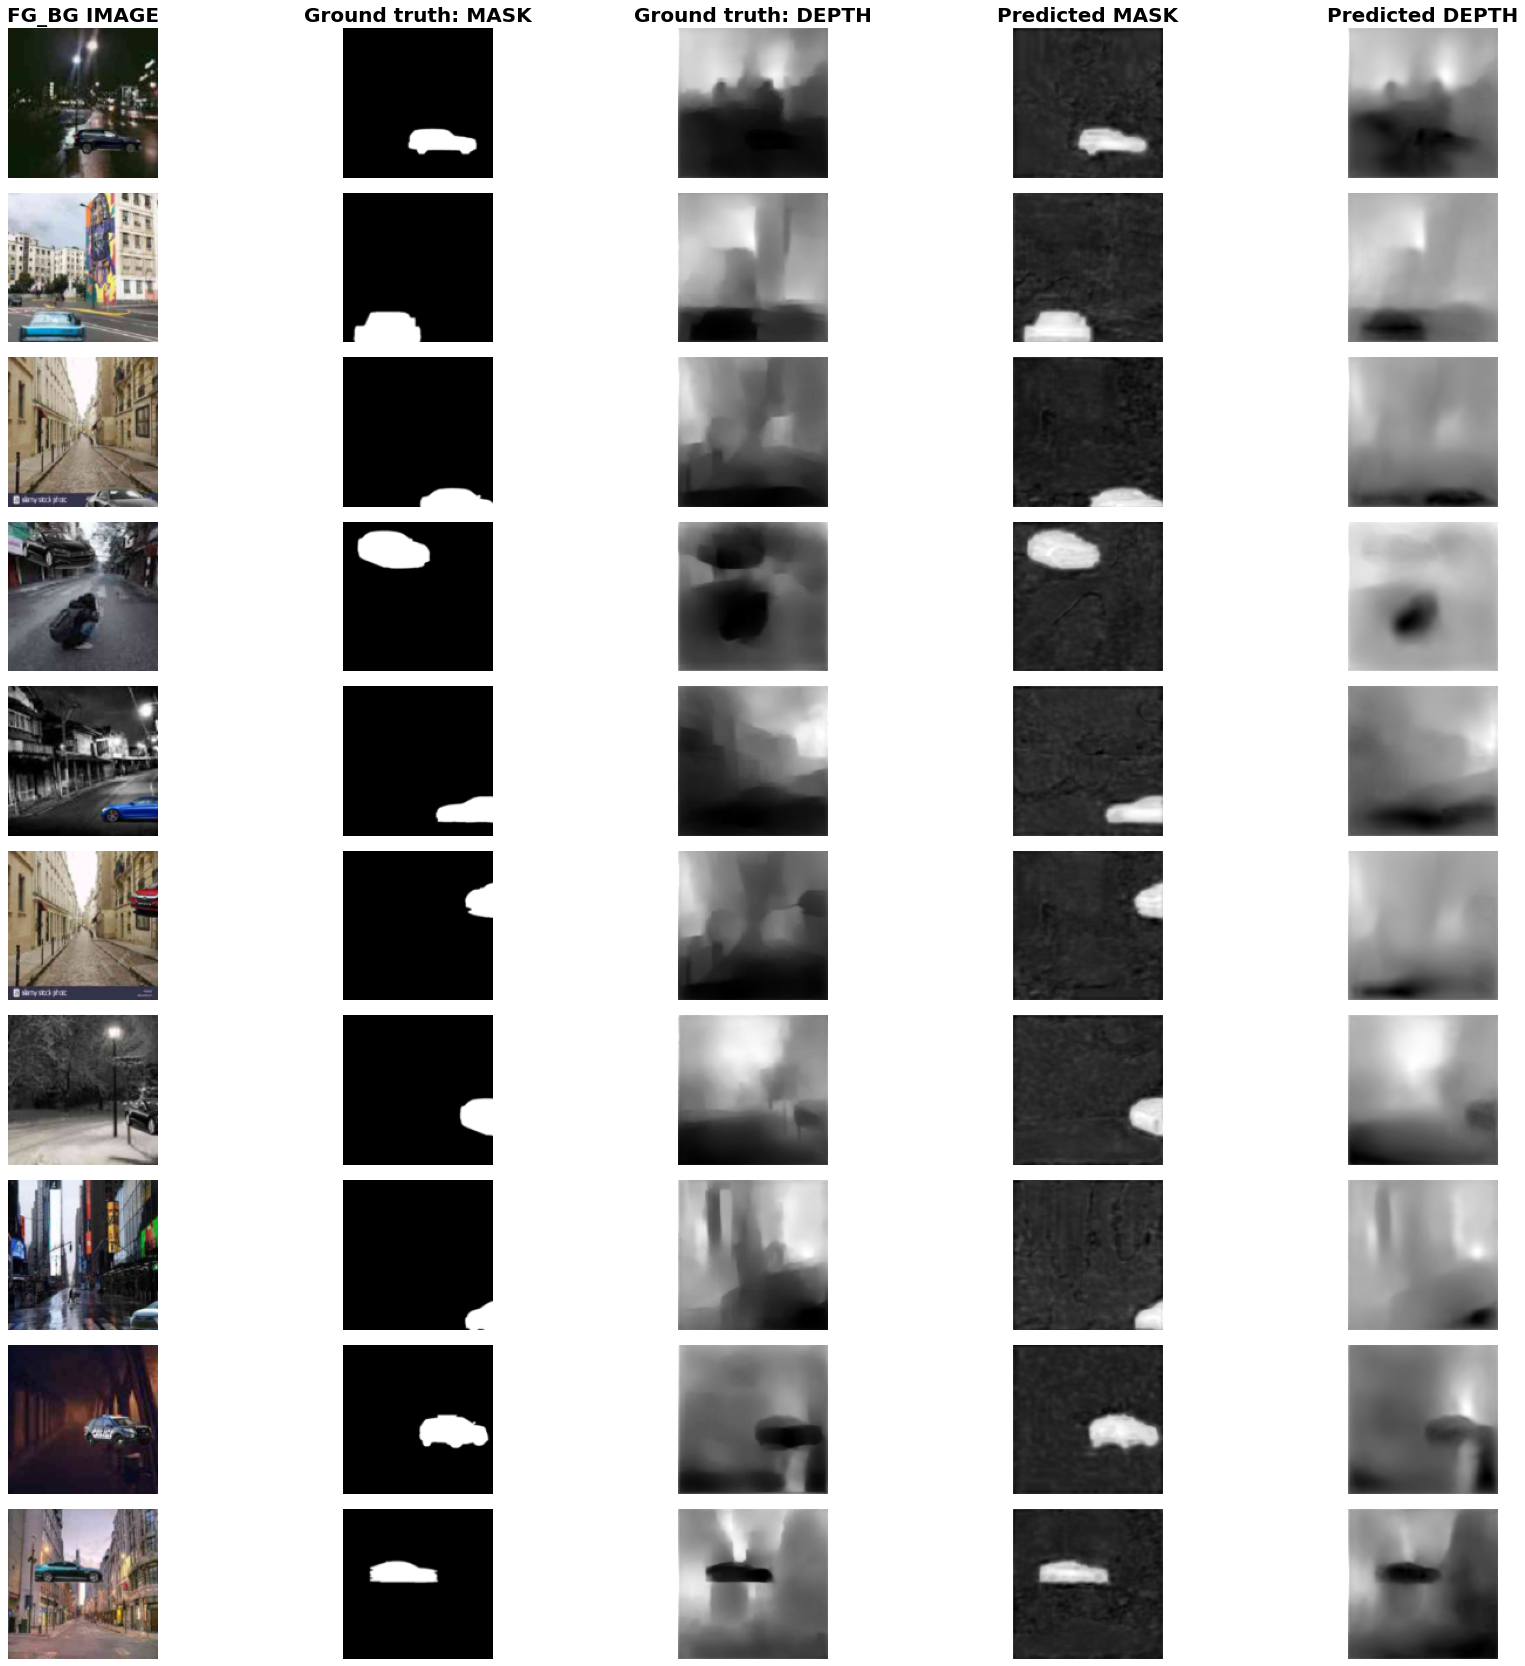

In [26]:
import numpy as np
from Eval_and_Plot_final import Result_Plot
test_loader = DataLoader(dataset=test_set, batch_size = 128, shuffle=False)
Result_Plot(test_loader, model, device, img_mean, img_std)




In [0]:
a = []
while(1):
    a.append('1')